In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Dropout,MaxPooling2D, Flatten, Lambda, ELU, Activation
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error


In [3]:
#function to remove spaces in the begining of the string 
def remove_spaces(images_path_with_spaces):

    for i in range(len(images_path_with_spaces)):
        string=images_path_with_spaces[i][0]

        string=string[1:]

        images_path_with_spaces[i][0]=string    

    return images_path_with_spaces

In [4]:
#load the paths of center cam images left cam and right cam images and correspoding recorded steering  

steering angles and corresponding paths of images where the steering is recorded
df = pd.read_csv("driving_log.csv")

#Remove images near zero steering which bias the conv network to predict zero steering
dropping_percent=80
dropping_thres=0.05#0.05
d=df.drop(df[(df['steering'] >-dropping_thres)&(df['steering']< dropping_thres)].sample(frac=dropping_percent/100).index)

#center cam images
images_path = d[[0]]
Ccam_images_path=images_path.values

#Left cam images
images_left_path = d[[1]]
Lcam_images_paths=images_left_path.values

Lcam_images_paths=remove_spaces(Lcam_images_paths)

#Right cam images
images_right_path = d[[2]]
Rcam_images_paths=images_right_path.values
Rcam_images_paths=remove_spaces(Rcam_images_paths)

st = d[[3]]
steer=st.values

extra_images_paths=[]
extra_steer=[]

In [6]:
#prints statistics of the steering data
def hist_mag_sum(left_right_straight_steering,thresholds):
    for i in range(len(thresholds)-1):
        start=thresholds[i]
        end=thresholds[i+1]
        cumsum=np.sum(left_right_straight_steering[(left_right_straight_steering>=start)&(left_right_straight_steering<end)])
        number=len(left_right_straight_steering[(left_right_straight_steering>=start)&(left_right_straight_steering<end)])
        print("sum between {0:0.2f} and {1:0.2f} is {2:0.2f} ----> number is {3:0.0f}".format(start,end,cumsum,number))
    print()    

splitting left right
len(steering) 12393


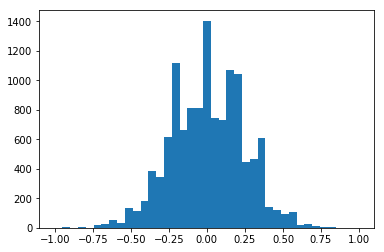

sum between -1.00 and -0.45 is -190.81 ----> number is 342
sum between -0.45 and -0.10 is -865.40 ----> number is 3709
sum between -0.10 and 0.00 is -92.92 ----> number is 1714
sum between 0.00 and 0.10 is 69.82 ----> number is 2019
sum between 0.10 and 0.45 is 966.26 ----> number is 4221
sum between 0.45 and 1.00 is 205.91 ----> number is 379

threshold for splitting into left and right -0.1 and 0.1

sum between -1.00 and -0.10 is -1056.21 ----> number is 4051
sum between -0.10 and 0.00 is -92.92 ----> number is 1714
sum between 0.00 and 0.10 is 69.82 ----> number is 2019
sum between 0.10 and 1.00 is 1172.17 ----> number is 4600

total length of available            12384
length of samples requested by user  9000
 length adjusted                     6346
steering values in thresholded regions before picking proportionately
342 3709 3733 4221 379 
steering values in thresholded regions after picking proportionately
279 1026 3732 1026 279 


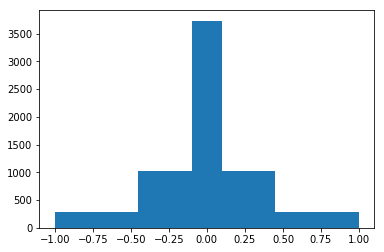

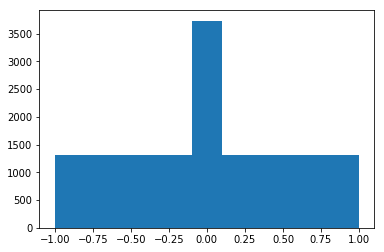

stats after extraction
sum between -1.00 and -0.45 is -156.18 ----> number is 279
sum between -0.45 and -0.10 is -241.71 ----> number is 1026
sum between -0.10 and 0.00 is -92.92 ----> number is 1714
sum between 0.00 and 0.10 is 69.82 ----> number is 2018
sum between 0.10 and 0.45 is 234.44 ----> number is 1026
sum between 0.45 and 1.00 is 152.04 ----> number is 279


stats after extraction
sum between -1.00 and -0.45 is -156.18 ----> number is 279
sum between -0.45 and -0.10 is -241.71 ----> number is 1026
sum between -0.10 and 0.10 is -23.10 ----> number is 3732
sum between 0.10 and 0.45 is 234.44 ----> number is 1026
sum between 0.45 and 1.00 is 152.04 ----> number is 279


sum between -1.00 and -0.10 is -397.89 ----> number is 1305
sum between -0.10 and 0.00 is -92.92 ----> number is 1714
sum between 0.00 and 0.10 is 69.82 ----> number is 2018
sum between 0.10 and 1.00 is 386.48 ----> number is 1305



In [7]:
#splits images into different sets based on steering thresholds
def split_left_right_straight(Images,steering,threshold):
    
    print("splitting left right")
    print("len(steering)",len(steering))
    
    plt.hist(steering,np.linspace(-1,1,40))
    plt.show()
    bins=[thresholds[0],thresholds[1],thresholds[2],0,thresholds[3],thresholds[4],thresholds[5]]
    hist_mag_sum(steering,bins)    
    
    print("threshold for splitting into left and right",threshold[2],"and",threshold[3])
    print()
    
    hist_mag_sum(steering,(-1,threshold[2],0,threshold[3],1))
    

    thresholded_images_stack=[]
    thresholded_steer_stack=[]
    for i in range(len(threshold)-1):
        thresholded_images_stack.append(  Images[ (steering>=threshold[i]) & (steering<threshold[i+1]) ]  )
        thresholded_steer_stack.append( steering[ (steering>=threshold[i]) & (steering<threshold[i+1]) ]  )
        
    
    return thresholded_images_stack,thresholded_steer_stack

#randomizes data and genreates fraction data based on desired sampling_ratioabilities 
def generate_indices_proportionately(thresholded_steer_stack,length,sampling_ratio):

    sampling_ratio=sampling_ratio/np.sum(sampling_ratio)
    
    all_indices=np.arange(  len( np.concatenate(thresholded_steer_stack,axis=0) )  )
    indices_for_each_stack=[]
    
    ctr=0
    for thresholded_steer in thresholded_steer_stack:
        indices_for_each_stack.append ( shuffle(all_indices[ctr:ctr+len(thresholded_steer)]) )
        ctr+=len(thresholded_steer)
    
    flag=False
    adjusted_len=10**10
    for i in range(len(sampling_ratio)):
        flag=flag or sampling_ratio[i]*length>len(indices_for_each_stack[i])
        adjusted_len=min(len(indices_for_each_stack[i])/sampling_ratio[i],adjusted_len)
        
    
    if length==[] or flag :
        print("total length of available           ",len(np.concatenate(thresholded_steer_stack,axis=0)))
        print("length of samples requested by user ",length)
        length=int(adjusted_len)
        print(" length adjusted                    ",length)
        
    proportionately_selected_indices_stack=[]    
    for i,indices_for_each in enumerate(indices_for_each_stack):
        proportionately_selected_indices_stack.append( indices_for_each[0:int(sampling_ratio[i]*length)] )
        
    print("steering values in thresholded regions before picking proportionately")
    for indices_for_each in indices_for_each_stack:
        print(len(indices_for_each),end=' ')
    print()    
    
    print("steering values in thresholded regions after picking proportionately")
    for proportionately_selected_indices in proportionately_selected_indices_stack:
        print(len(proportionately_selected_indices),end=' ')
    print()    
    
    return proportionately_selected_indices_stack


def generate_sample(Images,steering,length,thresholds,sampling_ratio):
    
    thresholded_images_stack,thresholded_steer_stack = split_left_right_straight(Images,steering,thresholds)
    
    left_right_straight_Images  =np.concatenate(thresholded_images_stack,axis=0)
    left_right_straight_steering=np.concatenate(thresholded_steer_stack,axis=0)
        
    left_right_straight_Images=left_right_straight_Images.reshape((len(left_right_straight_Images),1))
    left_right_straight_steering=left_right_straight_steering.reshape((len(left_right_straight_steering),1))    
    
    proportionately_selected_indices_stack=generate_indices_proportionately(thresholded_steer_stack,length,sampling_ratio)
    
    
    indices=np.concatenate(proportionately_selected_indices_stack,axis=0)
    return left_right_straight_Images[indices],left_right_straight_steering[indices]
    

#concatenates left right and camera images and also any extra images 
#generates a sample of the data from the concatenatd images based on steering thresholds and desired sampling ratio
def concatenate_LRcam_extra(images_path1,steer1,
                            images_path2,steer2,
                            lr_cam,
                            extra_images_paths=[],extra_steer=[],
                            length=[],
                            thresholds=(-1,-0.5,-0.25,0.25,0.5,1),
                            sampling_ratio=(1,1,1,1,1)):
    
    
    
    if len(extra_steer) !=0:
        combined_images_paths=np.vstack((images_path1,images_path2,extra_images_paths))
        if lr_cam:
            combined_steer=np.vstack((steer1+0.2,steer1-0.2,extra_steer))
        else:
            combined_steer=np.vstack((steer1,steer2,extra_steer))
            
    else:
        combined_images_paths=np.vstack((images_path1,images_path2))
        if lr_cam:
            combined_steer=np.vstack((steer1+0.2,steer1-0.2))
        else:
            combined_steer=np.vstack((steer1,steer2))
            
    
    
    
    left_right_straight_Images,left_right_straight_steering=generate_sample(combined_images_paths,
                                                                            combined_steer,
                                                                            length=length,
                                                                            thresholds=thresholds,
                                                                            sampling_ratio=sampling_ratio)
    
    
    plt.hist(left_right_straight_steering, bins=thresholds)
    plt.show()
    
    plt.hist(left_right_straight_steering, bins=[thresholds[0],thresholds[2],thresholds[3],thresholds[5]])
    plt.show()
    
    
    return left_right_straight_Images,left_right_straight_steering
        
max_left=-1
hard_left=-0.45   
soft_left=-0.1
soft_right=0.1
hard_right=0.45
max_right=1 

thresholds=(max_left,hard_left,soft_left,soft_right,hard_right,max_right)

hard_max_sampling_ratio=0.3
max_soft_sampling_ratio=1.1
soft_soft_sampling_ratio=2

hard_max_sampling_ratio/=2
max_soft_sampling_ratio/=2

sampling_ratio=(hard_max_sampling_ratio,max_soft_sampling_ratio,soft_soft_sampling_ratio,max_soft_sampling_ratio,hard_max_sampling_ratio)


left_right_straight_Images,left_right_straight_steering=concatenate_LRcam_extra(Lcam_images_paths,steer,
                                                                                Rcam_images_paths,steer,
                                                                                lr_cam=1,
                                                                                extra_images_paths=Ccam_images_path,extra_steer=steer,
                                                                                thresholds=thresholds,
                                                                                sampling_ratio=sampling_ratio,

                                                                                length=9000)
print("stats after extraction")
bins=[thresholds[0],thresholds[1],thresholds[2],0,thresholds[3],thresholds[4],thresholds[5]]
hist_mag_sum(left_right_straight_steering,bins)
print()


print("stats after extraction")
hist_mag_sum(left_right_straight_steering,thresholds)
print()

bins=[thresholds[0],thresholds[2],0,thresholds[3],thresholds[5]]
hist_mag_sum(left_right_straight_steering,bins)


(-1, -0.45, -0.1, 0.1, 0.45, 1)
279
-0.705992


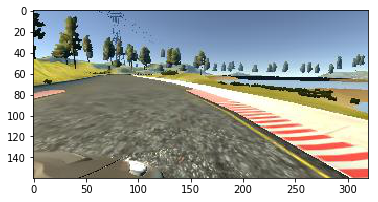

In [75]:
print(thresholds)
#left_right_straight_Images,left_right_straight_steering

img=left_right_straight_Images[(left_right_straight_steering>=-1)& (left_right_straight_steering<-0.45)]
ste=left_right_straight_steering[(left_right_straight_steering>=-1)& (left_right_straight_steering<-0.45)]

print(len(img))
a=np.random.randint(len(img))
im=mpimg.imread(img[a])
print(ste[a])
plt.imshow(im)
plt.show()

In [11]:
X_train,X_test,y_train,y_test = train_test_split(left_right_straight_Images, left_right_straight_steering, test_size=0.2, random_state=42)

6342
0
0.0


In [12]:
#python generator yields data(images) and steering in batches:
def data_generator(Images,steering,training=0,batch_size=128,threshold=2):

    ctr=0

    while( (training and ctr<len(steering) ) or (not training) ) :
    
        if ((not training) and (ctr>=len(steering))):
            ctr=0

        data,labels=preprocess(Images[ctr:ctr+batch_size],steering[ctr:ctr+batch_size],threshold)    
        ctr +=batch_size

        yield data,labels

#crops image to remove top and bottom of the images which are irrelavant         
def crop(img):
    new_size_col=200
    new_size_row=66
    img=img[60:145,:,:]
    img=cv2.resize(img,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)
    return img

#randomly changes brightness of images
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = max(np.random.uniform(),0.25)
    
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1
        

#preprocess images by cropping and flipping images to generate more data
#which balances steering in both directions
#Also randomly changes brightness of images

def preprocess(Images,steering,threshold):
    
    row,col,ch=(mpimg.imread((Images[0]).item())).shape

    img=[]
    steer=[]
        
    for i,path in enumerate(Images):

        I=mpimg.imread(path.item())
 
        if(np.random.randint(2)):
            I=augment_brightness_camera_images(I)            
            
        img.append(crop(I))
        steer.append(steering[i])

        if steering[i]<-threshold or steering[i]>threshold :
            I=np.fliplr(I)
            img.append(crop(I))
            steer.append(-steering[i])
    
    return np.asarray(img),np.asarray(steer)

len(train_labels)= 6900


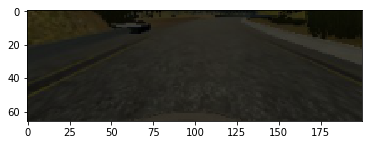

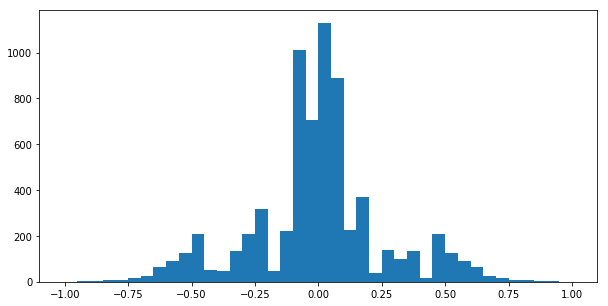

In [16]:
train_threshold=-thresholds[1]
train_batch=data_generator(X_train,y_train,training=1,batch_size=128,threshold=train_threshold)

labels=[]
data=[]

try:
    count=0
    while 1:
        batch_x,batch_y=next(train_batch)
        
        if count==0:                        
            plt.imshow(batch_x[1].astype(np.uint8))
            
        count=count+1
        
        labels.append(batch_y)
        data.append(batch_x)
        
except StopIteration:
    pass

train_labels=np.concatenate( labels, axis=0 )

print("len(train_labels)=",len(train_labels))

plt.figure(figsize=(10,5))
plt.hist(train_labels,np.linspace(-1, 1, num=41))
plt.show()



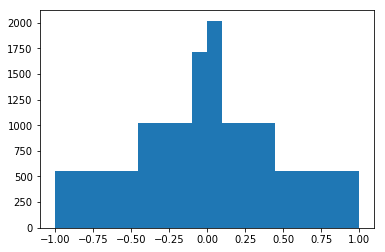

sum between -1.00 and -0.45 is -308.22 ----> number is 558
sum between -0.45 and -0.45 is 0.00 ----> number is 0
sum between -0.45 and -0.10 is -241.71 ----> number is 1026
sum between -0.10 and 0.00 is -92.92 ----> number is 1714
sum between 0.00 and 0.10 is 69.82 ----> number is 2018
sum between 0.10 and 0.45 is 234.44 ----> number is 1026
sum between 0.45 and 0.45 is 0.00 ----> number is 0
sum between 0.45 and 1.00 is 308.22 ----> number is 558

sum between -1.00 and -0.45 is -156.18 ----> number is 279
sum between -0.45 and -0.10 is -241.71 ----> number is 1026
sum between -0.10 and 0.10 is -23.10 ----> number is 3732
sum between 0.10 and 0.45 is 234.44 ----> number is 1026
sum between 0.45 and 1.00 is 152.04 ----> number is 279



In [17]:
bins=[thresholds[0],thresholds[1],thresholds[2],0,thresholds[3],thresholds[4],thresholds[5]]
bins.append(train_threshold)
bins.append(-train_threshold)
bins=np.sort(bins)

plt.hist(train_labels,bins=bins)
plt.show()
hist_mag_sum(train_labels,bins)


hist_mag_sum(left_right_straight_steering,thresholds)

In [18]:
X_tra,X_test,y_tra,y_test = train_test_split(left_right_straight_Images, left_right_straight_steering, test_size=0.2, random_state=42)


len(batch_y) 129
len(batch_y) 128
len(batch_y) 132
len(batch_y) 132
len(batch_y) 135
len(batch_y) 129
len(batch_y) 130
len(batch_y) 132
len(batch_y) 131
len(batch_y) 118
len(test_labels) 1296


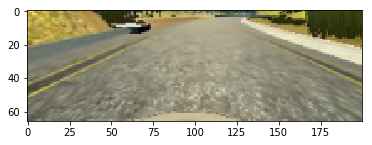

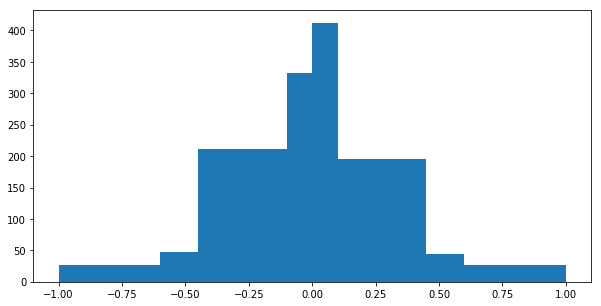

In [19]:
test_threshold=0.6
test_batch=data_generator(X_test,y_test,training=1,batch_size=128,threshold=test_threshold)


labels=[]

try:
    count=0
    while 1:
        batch_x,batch_y=next(test_batch)
        print("len(batch_y)",len(batch_y))
        if count==0:            
            plt.imshow(batch_x[1].astype(np.uint8))
        count=count+1

        labels.append(batch_y)
except StopIteration:
    pass

test_labels=np.concatenate( labels, axis=0 )

bins=[thresholds[0],thresholds[1],thresholds[2],0,thresholds[3],thresholds[4],thresholds[5]]
bins.append(test_threshold)
bins.append(-test_threshold)
bins=np.sort(bins)

print("len(test_labels)",len(test_labels))

plt.figure(figsize=(10,5))
plt.hist(test_labels,bins=bins)
plt.show()



In [23]:
print("train_labels,test_labels",len(train_labels),len(test_labels))
print("ratio of test to train=",len(test_labels)/len(train_labels))

samples_per_epoch=len(train_labels)
nb_val_samples=len(test_labels)

print("samples_per_epoch=",samples_per_epoch)
print("nb_val_samples=",nb_val_samples)

train_labels,test_labels 6900 1296
ratio of test to train= 0.18782608695652173
samples_per_epoch= 6900
nb_val_samples= 1296


In [24]:
from keras.models import Sequential
from keras.optimizers import Adam

In [25]:
row=66
col=200
ch=3
model = Sequential()

model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(row, col, ch)))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
model.add(Activation('relu'))

model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
model.add(Activation('relu'))

model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init="he_normal"))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init="he_normal"))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init="he_normal"))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Activation('relu'))


model.add(Dense(100, init="he_normal"))
model.add(Activation('relu'))

model.add(Dense(50, init="he_normal"))
model.add(Activation('relu'))

model.add(Dense(10, init="he_normal"))
model.add(Activation('relu'))
model.add(Dense(1, init="he_normal"))

model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 66, 200, 3)    0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_2[0][0]                   
____________________________________________________________________________________________________
activation_9 (Activation)        (None, 31, 98, 24)    0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 14, 47, 36)    21636       activation_9[0][0]               
___________________________________________________________________________________________

In [26]:
from keras.optimizers import Adam

model.compile(loss="mean_squared_error", optimizer="adam")

In [27]:
print(samples_per_epoch)
model.fit_generator(data_generator(X_train,y_train,training=0,batch_size=128,threshold=train_threshold),
                    samples_per_epoch=samples_per_epoch,
                    validation_data=data_generator(X_test,y_test,training=0,batch_size=128,threshold=test_threshold),
                    nb_val_samples=nb_val_samples,                    
                    nb_epoch=5,
                    verbose=2)
                    

6900
Epoch 1/5
20s - loss: 0.2108 - val_loss: 0.0495
Epoch 2/5
16s - loss: 0.0529 - val_loss: 0.0354
Epoch 3/5
16s - loss: 0.0409 - val_loss: 0.0284
Epoch 4/5
16s - loss: 0.0359 - val_loss: 0.0269
Epoch 5/5
16s - loss: 0.0335 - val_loss: 0.0264


In [48]:
import json
json_string = model.to_json()
json.dump(json_string, open("model.json", "w"))
model.save_weights('model.h5')